In [20]:
import jax.numpy as jnp
import liesel.goose as gs
import optax
import tensorflow_probability.substrates.jax.distributions as tfd
from liesel_ptm.util.plots import plot_loss, plot_param_history

import ppptm as gptm

In [21]:
def opt1():
    # Define the learning rate scheduler
    scheduler = optax.cosine_decay_schedule(init_value=0.01, decay_steps=2000)

    # Define the AdamW optimizer with weight decay
    adamw_optimizer = optax.adamw(learning_rate=scheduler, weight_decay=1e-4)

    gradient_clipping = optax.clip_by_global_norm(1.0)

    # Combine them using optax.chain
    combined_optimizer = optax.chain(gradient_clipping, adamw_optimizer)
    return combined_optimizer

In [22]:
data = gptm.load_americas()

In [23]:
locs = gptm.LocationVars.new_from(data.locs, n_subset=256)
y = data.obs[:, locs.locs.ordering]
model = gptm.Model.new_HG(
    y,
    locs,
    g_dist=gptm.G(y, locs, ard=True).new_gaussian(),
    coef=gptm.H(
        locs,
        ard=True,
        locwise_amplitude=True,
        # amplitude_prior=lsl.Dist(
        #     tfd.Weibull, concentration=jnp.array(0.5), scale=jnp.array(0.5)
        # ),
    ).new_coef(),
)

In [24]:
result = model.fit(
    stopper=gs.Stopper(max_iter=2_000, patience=30),
    optimizer=opt1(),
    progress_bar=True,
)

Training loss: 429298.500, Validation loss: 429298.500:  14%|█▍        | 284/2000 [00:19<01:45, 16.28it/s] 

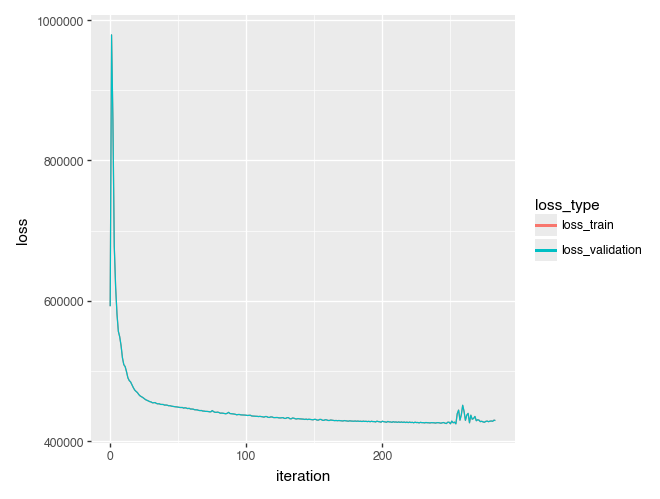

In [25]:
plot_loss(result)

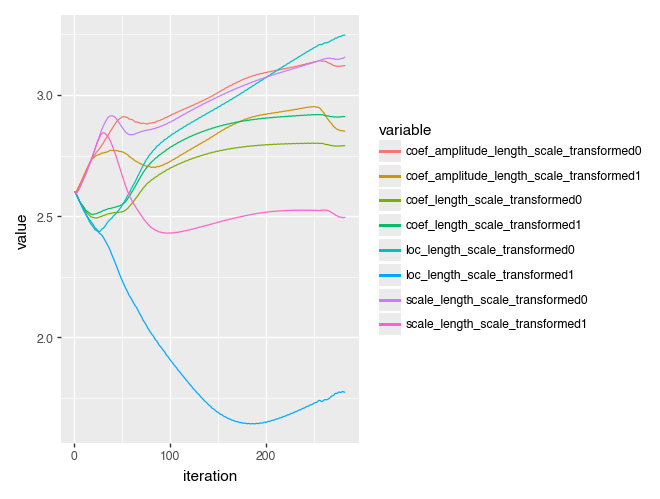

In [26]:
d = {k: v for k, v in result.history["position"].items() if "length_scale" in k}
plot_param_history(d)

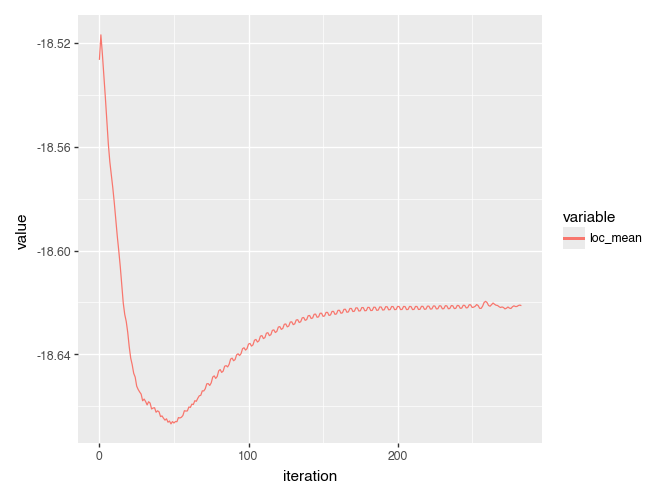

In [27]:
d = {k: v for k, v in result.history["position"].items() if "loc_mean" in k}
plot_param_history(d)

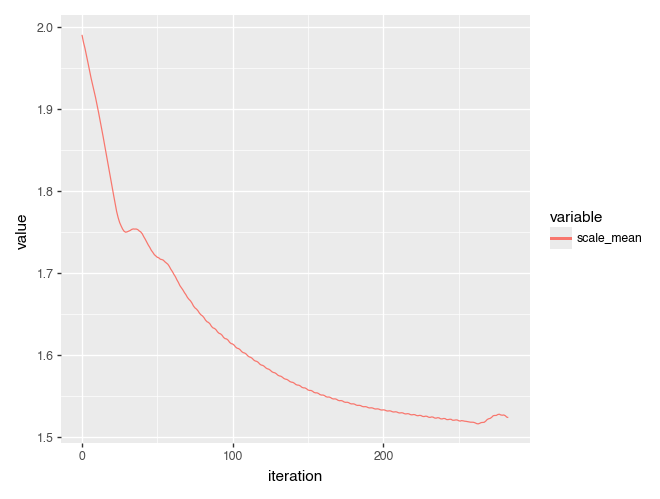

In [28]:
d = {k: v for k, v in result.history["position"].items() if "scale_mean" in k}
plot_param_history(d)

In [29]:
df = gptm.long_df_multiple(
    locs.locs.ordered,
    mu=model.graph.vars["loc"].value,
    sigma=model.graph.vars["scale"].value,
)

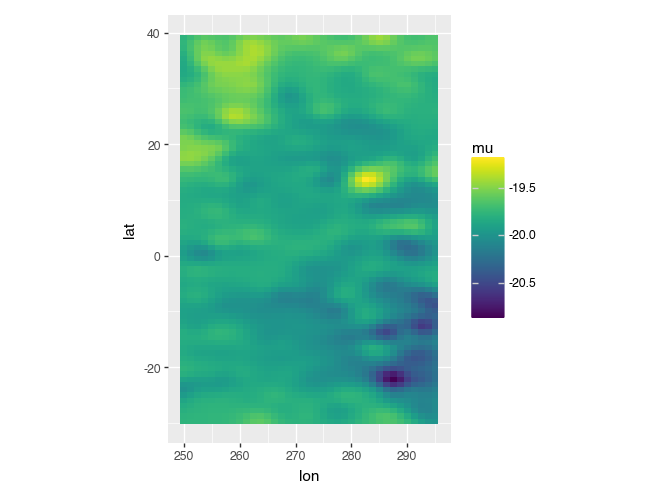

In [30]:
gptm.plot_df(df, "mu")

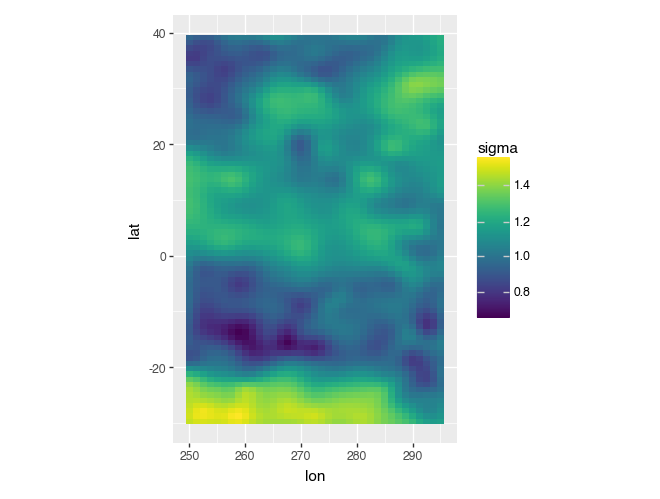

In [31]:
gptm.plot_df(df, "sigma")

In [32]:
model.coef.value.shape

(2738, 40)

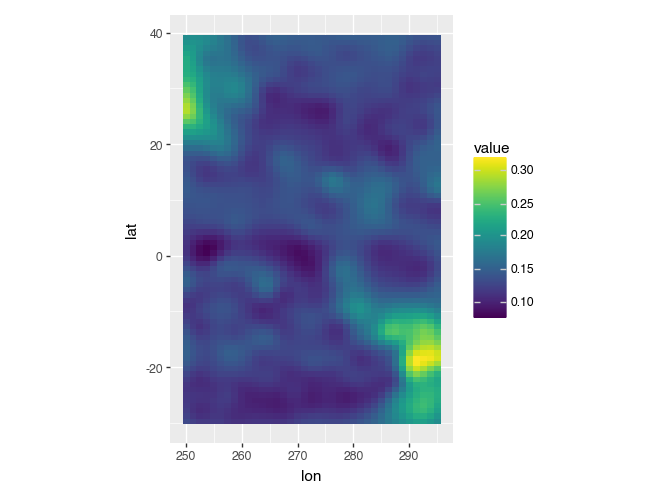

In [33]:
df = gptm.long_df(locs.locs.ordered, model.coef.amplitude.value)
gptm.plot_df(df)

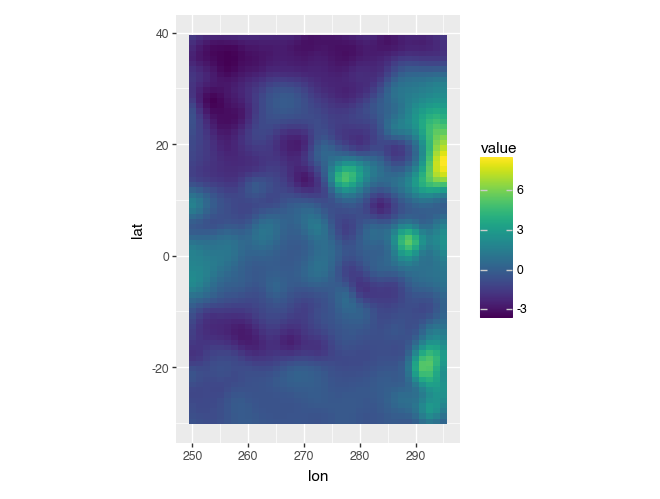

In [34]:
df = gptm.long_df(locs.locs.ordered, model.coef.value.T)
gptm.plot_df(df.query("obs == 20"))

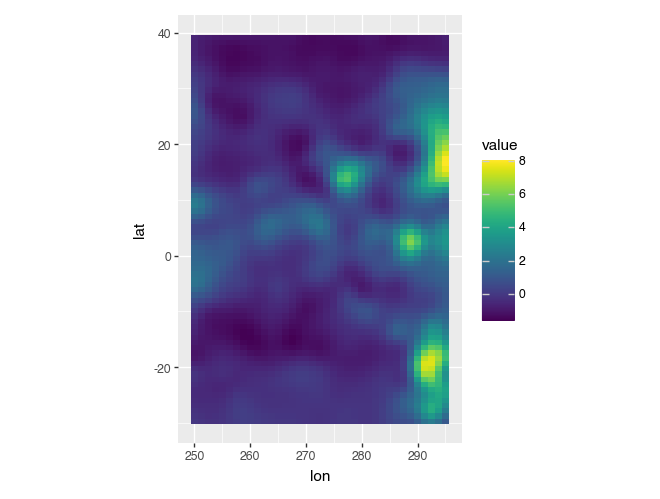

In [35]:
gptm.plot_df(df.query("obs == 30"))

In [36]:
from jax.random import key

samp = model.init_dist().sample((500), seed=key(2))
m = samp.mean(axis=0, keepdims=True)
s = samp.std(axis=0, keepdims=True)

In [37]:
grid = jnp.linspace(-6.0, 6.0, 301)
grid = jnp.expand_dims(grid, -1)
grid = jnp.tile(grid, locs.locs.nloc)

grid2 = s * grid + m
logdet1 = jnp.log(s)
zt, logdet2 = model.init_dist().transformation_and_logdet(grid2)
lp = tfd.Normal(loc=0.0, scale=1.0).log_prob(zt) + logdet1 + logdet2
pdf = jnp.exp(lp)

df = gptm.long_df_multiple(locs.locs.ordered, pdf=pdf, grid=grid, zt=zt, grid2=grid2)

y2 = (y - y.mean(axis=0, keepdims=True)) / y.std(axis=0, keepdims=True)
df2 = gptm.long_df(locs.locs.ordered, y2)

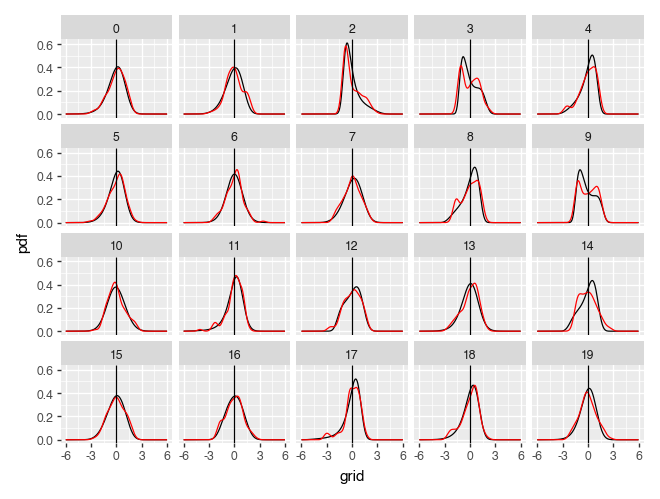

In [38]:
import plotnine as p9

(
    p9.ggplot(df.query("loc < 20"))
    + p9.geom_line(p9.aes("grid", "pdf"))
    + p9.geom_density(p9.aes("value"), color="red", data=df2.query("loc < 20"))
    + p9.geom_vline(p9.aes(xintercept=0.0))
    + p9.facet_wrap("~loc")
    # + p9.xlim((-5.0, 5.0))
)